# Lab 11 - Graph Data Analytics

Complete the code with TODO tag.

If you haven't installed networkx package, you can run the following command (note the exclamation mark)

```bash
!conda install networkx --yes
```

In [1]:
import networkx as nx
import numpy as np

## 1. Centrality Analysis
In this exercise, you will implement the pagerank centrality.

In [2]:
import matplotlib.pyplot as plt

def pagerank_centrality(G, iter=100):
    p = np.array([1 for i in G.nodes()])
    print(p.size)
#     object_methods = [method_name for method_name in dir(G)
#                   if callable(getattr(G, method_name))]
#     print(object_methods)
    print(nx.degree_centrality(G))
    for k in range(iter):
        for i in G.nodes():
            for j in G.nodes():
                # TODO: update the centrality
                p[i] += 1 if j in G.neighbors(i) else 0
        
        # TODO: Normalize the centrality value to avoid overflow of numerical computation
        norm = p.size
        p = p / norm 
        
    print(p)
    return p

G = nx.karate_club_graph()
print(nx.info(G))
values = pagerank_centrality(G)
nx.draw(G, cmap=plt.get_cmap('Reds'), node_color = values, with_labels=True)

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882
34
{0: 0.48484848484848486, 1: 0.2727272727272727, 2: 0.30303030303030304, 3: 0.18181818181818182, 4: 0.09090909090909091, 5: 0.12121212121212122, 6: 0.12121212121212122, 7: 0.12121212121212122, 8: 0.15151515151515152, 9: 0.06060606060606061, 10: 0.09090909090909091, 11: 0.030303030303030304, 12: 0.06060606060606061, 13: 0.15151515151515152, 14: 0.06060606060606061, 15: 0.06060606060606061, 16: 0.06060606060606061, 17: 0.06060606060606061, 18: 0.06060606060606061, 19: 0.09090909090909091, 20: 0.06060606060606061, 21: 0.06060606060606061, 22: 0.06060606060606061, 23: 0.15151515151515152, 24: 0.09090909090909091, 25: 0.09090909090909091, 26: 0.06060606060606061, 27: 0.12121212121212122, 28: 0.09090909090909091, 29: 0.12121212121212122, 30: 0.12121212121212122, 31: 0.18181818181818182, 32: 0.36363636363636365, 33: 0.5151515151515151}
[0.48484848 0.27272727 0.3030303  0.18181818 0.09090

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


## 2. Community Analysis

### 2.1. Clique Percolation Method

One well-known algorithm for detecting overlapping communities is called the Clique Percolation Method (CPM).

In [3]:
from itertools import combinations

def get_percolated_cliques(G, k):
    perc_graph = nx.Graph()
    
    # TODO: find cliques of the graph
    cliques = [frozenset(c) for c in nx.find_cliques(G) if len(c) >= k]
    perc_graph.add_nodes_from(cliques)
    
    # TODO: Add an edge in the clique graph for each pair of cliques that percolate
    for c1, c2 in combinations(cliques, 2):
        if (len(c1.intersection(c2)) >= (k-1)):
            perc_graph.add_edge(c1, c2)

    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

In [4]:
get_percolated_cliques(G, 3)

<generator object get_percolated_cliques at 0x7fd4bc83ad68>

Test with a small dataset

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882
---0.0001285076141357422 seconds---


/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


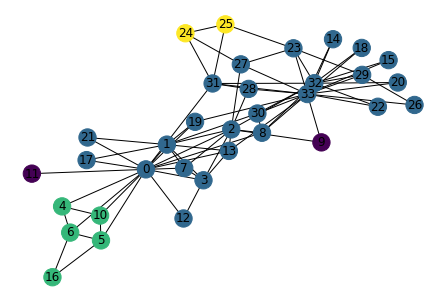

In [7]:
def partition(communities):
    node2communities = dict()
    
    # TODO: transform the community information to partition assignment for data visualization
    for index, community in enumerate(communities):
        for node in community:
            if node in node2communities.keys():
                node2communities[node].append(index)
            else:
                node2communities[node] = [index]
    return node2communities # return a dict
            
G = nx.karate_club_graph()
print(nx.info(G))

import time
start_time = time.time()
communities = get_percolated_cliques(G,3)

print("---{0} seconds---".format(time.time() - start_time))
part = partition(communities)
values = [part.get(node,[-1])[0] for node in G.nodes()]

nx.draw(G, node_color = values, with_labels=True)

### 2.2. Efficient Implementation
That implementation is correct but expensive---it requires O(N^2) clique comparisons, where N is the number of cliques (which is often much larger than the number of nodes!).  If we use a python dictionary to index which nodes belong to which cliques, then we can easily compare only those cliques that share at least one node in common.  This implementation is a bit longer but should be more efficient:

---0.0001540184021 seconds---


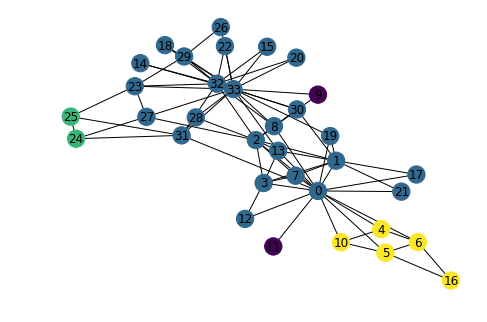

In [71]:
from collections import defaultdict

def get_percolated_cliques2(G, k):
    perc_graph = nx.Graph()
    cliques = [frozenset(c) for c in nx.find_cliques(G) if len(c) >= k]
    perc_graph.add_nodes_from(cliques)

    # First index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # For each clique, see which adjacent cliques percolate
    for clique in cliques:
        for adj_clique in get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Connected components of clique graph with perc edges
    # are the percolated cliques
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

def get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    
    # TODO: get adjacent cliques
    
    return adjacent_cliques

start_time = time.time()
communities = get_percolated_cliques2(G,3)
print("---{0} seconds---".format(time.time() - start_time))
part = partition(get_percolated_cliques2(G,3))

values = [part.get(node,[-1])[0] for node in G.nodes()]

nx.draw(G, node_color = values, with_labels=True)

### 2.3. Test with large dataset

Now we test with a real large-scale network data at https://snap.stanford.edu/data/com-Amazon.html

In [72]:
# G = nx.read_edgelist("email-Eu-core.txt")
G = nx.read_edgelist("com-amazon.ungraph.txt")
print(nx.info(G))

start_time = time.time()
communities = get_percolated_cliques(G, 3)
print("---{0} seconds---".format(time.time() - start_time))

start_time = time.time()
communities = get_percolated_cliques2(G, 3)
print("---{0} seconds---".format(time.time() - start_time))

Name: 
Type: Graph
Number of nodes: 334863
Number of edges: 925872
Average degree:   5.5299
---0.0001220703125 seconds---
---0.000126123428345 seconds---
